In [1]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import glob, os
import numpy as np
import csv
import pandas as pd
import seaborn as sns
import librosa
sns.set_style("whitegrid")
from IPython.display import Markdown, display, Audio
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
sys.path.insert(0, os.path.abspath('../../../../cleese'))
import cleese

In [3]:
# Load Voimooo python wrapper
sys.path.insert(0, os.path.abspath('../../../../pyvoimooo/'))
import pyvoimooo as vmo
vmo.__version__

INFO: Wav write/read: Using libsndfile in Voimooo


'0.17.6'

In [4]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   ../neurobs_presentation/own_name.exp
	modified:   ../python/.ipynb_checkpoints/Untitled-checkpoint.ipynb
	modified:   ../python/Untitled.ipynb
	modified:   ../python/own_name.py
	deleted:    ../python/sounds/rise/julie/julie_fall.wav
	deleted:    ../python/sounds/rise/julie/julie_neutral.wav
	deleted:    ../python/sounds/rise/julie/julie_rise.wav
	deleted:    ../python/sounds/rise/nassim/nassim_fall.wav
	deleted:    ../python/sounds/rise/nassim/nassim_neutral.wav
	deleted:    ../python/sounds/rise/nassim/nassim_rise.wav
	deleted:    ../python/sounds/rise/pauline/pauline_fall.wav
	deleted:    ../python/sounds/rise/pauline/pauline_neutral.wav
	deleted:    ../python/sounds/rise/pauline/pauline_rise.wav
	deleted:    ../python/sounds/rise/subj24/lucie_f

# Stimulus Generation

Generate stimuli for own-name (Pruvost-Robieux et al., 2021) and own-name rev or (Joucla et al. 2021) experiments\
&copy; JJ Aucouturier, 2021

## Utilities

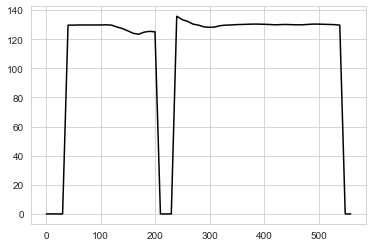

In [7]:
import pysptk

WIN_PITCH= 0.01
BOUNDS=[30,300]

def extract_pitch(x, sr, win, bounds, best_of_n =10):
    """Computes pitch on successive windows (size win, in samples), 
    and returns an array of pitch values (in Hz) and array of window time positions (in ms).
    bounds = [min_f0,max_f0] in which the pitch should be searched.
    """
    hop_size = np.floor(sr * win)
    min_f0, max_f0 = bounds
    
    # for some reason, the algorithm is stochastic and may underselect pitched areas
    # we take the best_of_n run returning most nb of non zero values
    pitch = pysptk.swipe(x.astype(np.float64), fs=sr, hopsize=hop_size, min=min_f0, max=max_f0, otype=1, threshold=0.3)
    non_zeros = len(np.where(pitch > 0)[0])
    for run in np.arange(0,best_of_n): 
        new_run = pysptk.swipe(x.astype(np.float64), fs=sr, hopsize=hop_size, min=min_f0, max=max_f0, otype=1, threshold=0.3)
        run_non_zeros = len(np.where(new_run > 0)[0])
        if (run_non_zeros >= non_zeros): 
            pitch = new_run
            non_zeros = run_non_zeros
            
    times = 1000*np.arange(len(pitch))*hop_size/sr
    return times,np.array(pitch) 

wave_in, sr = librosa.load('sounds\\quentin.wav')
times,pitch = extract_pitch(wave_in,sr,WIN_PITCH,BOUNDS, best_of_n=10)
plt.plot(times,pitch,'k')

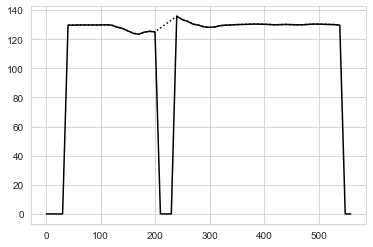

In [8]:
import math
def interpolate_pitch(pitch, method, start_value, end_value): 
    """Interpolate zeros in pitch series. Method = spline (order-3 polynomial), linear or none. 
    Provide start_value, end_value to fix bounds. 
    """
    if method == 'spline' :
        order = 3
        pitch_interp = np.copy(pitch)
        pitch_interp[0:1] = start_value #math.log(spline_start)
        pitch_interp[-2:] = end_value # math.log(spline_end)
        pitch_interp = np.array(pd.Series(pitch_interp).interpolate(method='polynomial', order=order))
    
    elif method == 'linear' :
        xp=np.where(np.invert(list(map(math.isnan, pitch))))[0]
        fp=np.array(pitch)[np.where(np.invert(list(map(math.isnan, pitch))))]
        pitch_interp = np.interp(x=range(len(pitch)),
                                 xp=xp,
                                 fp=fp)
    elif method == 'none' :
        pitch_interp = np.copy(pitch)
        pitch_interp[np.nonzero(np.isnan(pitch))] = 0
    
    return pitch_interp

wave_in, sr = librosa.load('sounds\\quentin.wav')
times, pitch = extract_pitch(wave_in,sr,WIN_PITCH, BOUNDS)
plt.plot(times,pitch,'k')
pitch[np.where(pitch == 0)] = np.nan
# trim beginning and end nans
notnans = np.flatnonzero(~np.isnan(pitch))
if notnans.size:
    pitch = pitch[notnans[0]: notnans[-1]+1]
    times = times[notnans[0]: notnans[-1]+1]
else: 
    pitch = times = []
# interpolate nans
start_value = end_value = np.mean(pitch[np.nonzero(~np.isnan(pitch))])
pitch_interp = interpolate_pitch(pitch,
                                 method='linear',
                                 start_value = start_value, 
                                 end_value = end_value)
plt.plot(times,pitch_interp,'k:')

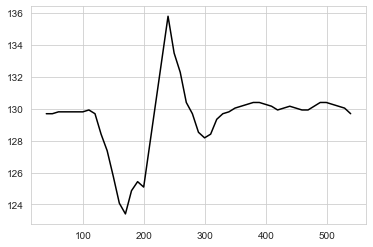

In [9]:
def extract_pitch_interp(wave_in, sr, method='linear'): 
    
    times, pitch = extract_pitch(wave_in,sr, win=WIN_PITCH, bounds=BOUNDS)
    pitch[np.where(pitch == 0)] = np.nan
    
    # trim beginning and end nans
    notnans = np.flatnonzero(~np.isnan(pitch))
    if notnans.size:
        pitch = pitch[notnans[0]: notnans[-1]+1]
        times = times[notnans[0]: notnans[-1]+1]
    else: 
        pitch = times = []
       
    # interpolate nans
    start_value = end_value = np.mean(pitch[np.nonzero(~np.isnan(pitch))])
    pitch_interp = interpolate_pitch(pitch,
                                 method=method,
                                 start_value = start_value, 
                                 end_value = end_value)
    
    return times, pitch_interp

wave_in, sr = librosa.load('sounds\\quentin.wav')
times, pitch_interp = extract_pitch_interp(wave_in, sr, method='linear')
plt.plot(times,pitch_interp,'k')

## Text-to-Speech (TTS)

Generate name wav file from https://rec.alta-voce.tech/ \
We use the male voice ("Nicolas")
Note: sometimes better results with "Corentin..." than "Corentin" because it's flatter to start with.

## Preprocessing

Cut trailing silence in the beginning (typically 50-200ms) and end + normalise amplitude (0 offset + -1dB crête). \
This is done by hand, in audacity for now.

## Flatten prosody

TTS recordings have an arbitrary prosody, which we suspect has influence on the electrophysiological properties of the P3 response (Pruvost-Robieux et al, 2021). We use VMO/CLEESE to flatten the file (http://voimooo.alta-voce.tech)

E:\WORK\DO\2020\cleese\cleese\cleeseProcess.py:176: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,wave = wav.read(fileName)


Original file:

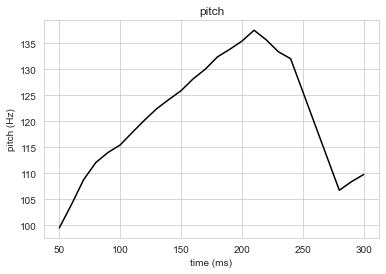

In [20]:
# original file
input_file = 'sounds\\aude\\aude.wav'
wave_in,sr, fmt = cleese.wavRead(input_file)

display(Markdown("Original file:"))
times,pitch = extract_pitch_interp(wave_in,sr, method='linear')
_=plt.plot(times,pitch,'k');
_=plt.title('pitch')
_=plt.ylabel('pitch (Hz)')
_=plt.xlabel('time (ms)')
Audio(data=wave_in, rate=sr)


To flatten this existing contour, we construct a custom breakpoint function that passes through the pitch shift values needed to shift the contour down to a constant pitch value, arbitrarily set here at 130Hz. 

We then apply this custom BPF to the original file, using ```vmo.pitch_scaling_snm(wave_in, sr, dpss=np.row_stack((bpf_times, bpf_shifts)))```. \
An alternative is to use ```cleese.process(soundData=wave_in, configFile=config_file, sr=sr, BPF=bpf)``` but the relatively large scaling involved in flattening files typically doesn't work very well with the simple vocoder of CLEESE v1. 

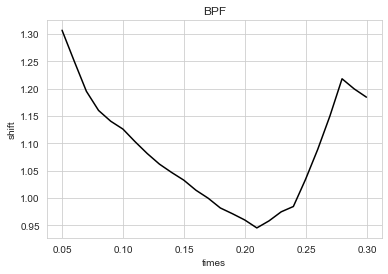

Transformed file:

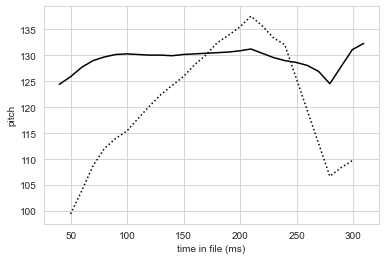

In [21]:
MEAN_PITCH =130

hop = 1
bpf_times = times[0::hop]/1000
bpf_shifts = MEAN_PITCH/pitch[0::hop]
_=plt.plot(bpf_times, bpf_shifts, 'k')
_=plt.title('BPF')
_=plt.xlabel('times')
_=plt.ylabel('shift')
plt.show()


wave_in,sr =  vmo.readwav(input_file)
wave_out, tts, f0s = vmo.pitch_scaling_snm(wave_in, sr, dpss=np.row_stack((bpf_times, bpf_shifts)))

# display transformed file
display(Markdown("Transformed file:"))
Audio(data=wave_out, rate=sr)
times_f, pitch_f = extract_pitch_interp(wave_out,sr, method='linear')
_=plt.plot(times, pitch, 'k:')
_=plt.plot(times_f, pitch_f, 'k')
_=plt.xlabel('time in file (ms)')
_=plt.ylabel('pitch')

input_file_flat = os.path.splitext(input_file)[0]+'_neutral.wav'
vmo.writewav(input_file_flat, sr, wave_out)

## Falling vs Raising prosody

We use the pitch profiles learned from Pruvost-Robieux et al. 2021 to create 2 variants for the experiment.

In [22]:
import pandas as pd
data = pd.read_csv('kernels.csv')

### Pitch via vmo

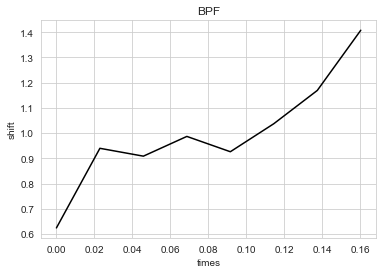

Transformed file:

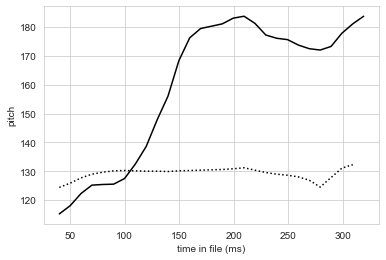

Transformed file:

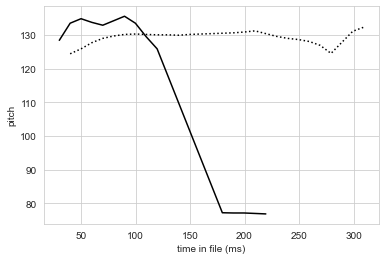

In [23]:
wave_in,sr =  vmo.readwav(input_file_flat)

# scale time to file duration
duration =len(wave_in)/sr
n_segments = len(data.t)
bpf_times = np.linspace(0,0.5*duration, n_segments)

#scale pitch to scale factors
pitch_scale = 2
bpf_shifts = 1.0 + pitch_scale * data.pitch.to_numpy()

_=plt.plot(bpf_times, bpf_shifts, 'k')
_=plt.title('BPF')
_=plt.xlabel('times')
_=plt.ylabel('shift')
plt.show()

# rising
wave_in,sr =  vmo.readwav(input_file_flat)
wave_out, tts, f0s = vmo.pitch_scaling_snm(wave_in, sr, dpss=np.row_stack((bpf_times, bpf_shifts)))

# display transformed file
display(Markdown("Transformed file:"))
Audio(data=wave_out, rate=sr)
times, pitch = extract_pitch_interp(wave_in,sr)
times_f, pitch_f = extract_pitch_interp(wave_out,sr)
_=plt.plot(times, pitch, 'k:')
_=plt.plot(times_f, pitch_f, 'k')
_=plt.xlabel('time in file (ms)')
_=plt.ylabel('pitch')
plt.show()

input_file_flat_rising = os.path.splitext(input_file)[0]+'_rise.wav'
vmo.writewav(input_file_flat_rising, sr, wave_out)

# falling
pitch_scale = -2
bpf_shifts = 1.0 + pitch_scale * data.pitch.to_numpy()

wave_out_2, tts, f0s = vmo.pitch_scaling_snm(wave_in, sr, dpss=np.row_stack((bpf_times, bpf_shifts)))

# display transformed file
display(Markdown("Transformed file:"))
Audio(data=wave_out_2, rate=sr)
times, pitch = extract_pitch_interp(wave_in,sr)
times_f, pitch_f = extract_pitch_interp(wave_out_2,sr)
_=plt.plot(times, pitch, 'k:')
_=plt.plot(times_f, pitch_f, 'k')
_=plt.xlabel('time in file (ms)')
_=plt.ylabel('pitch')
plt.show()

input_file_flat_falling = os.path.splitext(input_file)[0]+'_fall.wav'
vmo.writewav(input_file_flat_falling, sr, wave_out_2)




### RMS via CLEESE

## Smiling

In [24]:
SMILE_ALPHA = 1.3

# flat 
wave_in,sr =  vmo.readwav(input_file_flat)
wave_out, tts, f0s, envs_ori, envs_new = vmo.smile(wave_in, sr, alpha=SMILE_ALPHA)
vmo.writewav(os.path.splitext(input_file)[0]+'_smile.wav', sr, wave_out)

display(Markdown("Flat smiling:"))
Audio(data=wave_out, rate=sr)


# rising 
#wave_in,sr =  vmo.readwav(input_file_flat_rising)
#wave_out_2, tts, f0s, envs_ori, envs_new = vmo.smile(wave_in, sr, alpha=SMILE_ALPHA)
#vmo.writewav(os.path.splitext(input_file_flat_rising)[0]+'_smiling.wav', sr, wave_out_2)
#display(Markdown("Rise smiling:"))
#Audio(data=wave_out_2, rate=sr)



Flat smiling:

## Roughness

For now, this is done manually by Marco using ANGUS